<a href="https://colab.research.google.com/github/deveshdatwani/unet/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [141]:
import torch
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [142]:
from google.colab import drive
from torch.utils.data import DataLoader
drive.mount('/content/drive')
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize
import matplotlib.pyplot as plt
import pandas as pd
import os
from matplotlib import pyplot as plt
import cv2
from torchvision.io import read_image, ImageReadMode as iomode
from tqdm import tqdm
from torch import nn
from torch.optim import SGD, Adam
from torch.autograd import Variable

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [143]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3)
        self.conv2 = nn.Conv2d(64, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 128, 3)
        self.conv5 = nn.Conv2d(128, 256, 3)
        self.conv6 = nn.Conv2d(256, 256, 3)
        self.conv7 = nn.Conv2d(256, 512, 3)
        self.conv8 = nn.Conv2d(512, 512, 3)
        self.conv9 = nn.Conv2d(512, 1024, 3)
        self.conv10 = nn.Conv2d(1024, 1024, 3)
        self.conv11 = nn.Conv2d(1024, 512, 3)
        self.conv12 = nn.Conv2d(512, 512, 3)
        self.conv13 = nn.Conv2d(512, 256, 3)
        self.conv14 = nn.Conv2d(256, 256, 3)
        self.conv15 = nn.Conv2d(256, 128, 3)
        self.conv16 = nn.Conv2d(128, 128, 3)
        self.conv17 = nn.Conv2d(128, 64, 3)
        self.conv18 = nn.Conv2d(64, 64, 3)
        self.conv19 = nn.Conv2d(64, 2, 1)
        self.up1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.up4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.max1 = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=0)
        self.convoutput = nn.Conv2d(2,1,1)
        self.sa = nn.Sigmoid()


    def forward(self, x):
        x = self.relu(self.conv1(x))
        x1 = self.relu(self.conv2(x))
        x = self.max1(x1)
        x = self.relu(self.conv3(x))
        x2 = self.relu(self.conv4(x))
        x = self.max1(x2)
        x = self.relu(self.conv5(x))
        x3 = self.relu(self.conv6(x))
        x = self.max1(x3)
        x = self.relu(self.conv7(x))
        x4 = self.relu(self.conv8(x))
        x = self.max1(x4)
        x = self.relu(self.conv9(x))
        x = self.relu(self.conv10(x))
        x = self.up1(x)
        x = torch.cat((x4[:,:,4:-4,4:-4], x), dim=1)
        x = self.relu(self.conv11(x))
        x = self.relu(self.conv12(x))
        x = self.up2(x)
        x = torch.cat((x3[:,:,16:-16,16:-16], x), dim=1)
        x = self.relu(self.conv13(x))
        x = self.relu(self.conv14(x))
        x = self.up3(x)
        x = torch.cat((x2[:,:,40:-40,40:-40], x), dim=1)
        x = self.relu(self.conv15(x))
        x = self.relu(self.conv16(x))
        x = self.up4(x)
        x = torch.cat((x1[:,:,88:-88,88:-88], x), dim=1)
        x = self.relu(self.conv17(x))
        x = self.relu(self.conv18(x))
        x = self.relu(self.conv19(x))
        x = self.convoutput(x)

        return x

In [144]:
class Kvasir(Dataset):

    def __init__(self, root_dir, json=None):
       self.train_images_dir = os.path.join(root_dir, "images")
       self.masks_dir = os.path.join(root_dir, "masks")
       self.len = len(os.listdir(self.train_images_dir))
       self.train_images = [os.path.join(self.train_images_dir, i) for i in os.listdir(self.train_images_dir)]
       self.train_masks = [os.path.join(self.masks_dir, i) for i in os.listdir(self.masks_dir)]
       self.size = [572, 572]
       self.target_size = [388, 388]
       self.transform = None


    def __len__(self):

        return self.len
    

    def resize(self, im, label=False):
        if label:
          return Resize(self.target_size)(im)
        else:
          return Resize(self.size)(im)
    
    def __getitem__(self, idx):
        image_address = self.train_images[idx]
        mask_address = self.train_masks[idx]
        image = read_image(image_address)
        mask = read_image(mask_address, iomode.GRAY)
        image = self.resize(image, False).to(device=DEVICE)
        target = self.resize(mask, True).to(device=DEVICE)

        return image, target

In [145]:
class DiceLoss(nn.Module):
    
    def __init__(self, smooth=0.0001):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        
    
    def forward(self, prediction, target):
        prediction_flat = prediction.view(-1)
        target_flat = target.view(-1)
        # prediction[prediction > 0.05] = 1 
        # prediction[prediction < 0.05] = 0
        # plt.imshow(prediction[0].cpu().permute(1,2,0).detach().numpy(), cmap='gray')
        # plt.show()
        num = 2 * (torch.multiply(prediction_flat, target_flat).sum())
        den = torch.multiply(prediction_flat, prediction_flat).sum() + torch.multiply(target_flat, target_flat).sum()
        loss = 1 - ((num / (den + self.smooth))/2)

        return Variable(loss, requires_grad=True)

In [146]:
# TRAINING LOOP
class Trainer():
    def __init__(self, model=None, epochs=16, batch_size=2, path='/content/drive/MyDrive/Kvasir-SEG'):
        self.model = model
        self.epochs = epochs
        self.batch_size = batch_size
        self.dataset = Kvasir(path)
        self.train_dataloader = DataLoader(dataset=self.dataset, shuffle=True, batch_size=batch_size)
        self.optim = Adam(params=model.parameters(), lr=0.001)
        self.criterian = DiceLoss()
        self.PATH = "./model.pt"
        self.checkpoint = None


    def train(self):

        if "model.pt" in os.listdir():
            self.checkpoint = torch.load(self.PATH)
            self.model.load_state_dict(self.checkpoint['model_state_dict'])

        for epoch in tqdm(range(self.epochs)):
            running_loss = 0
            
            for i, data in enumerate(self.train_dataloader):
                instance, ground_truth = data
                prediction = self.model(instance.float())
                self.optim.zero_grad()
                loss = self.criterian(prediction, ground_truth)

                loss.backward()
                self.optim.step()
                running_loss += loss

                if i % 5 == 0:
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                         epoch, i * len(data), len(self.dataset),
                         100. * i / len(self.train_dataloader), running_loss/5))
                    running_loss = 0
                
                if i % 20 == 0:
                    torch.save({
                        'epoch': self.epochs,
                        'model_state_dict': self.model.state_dict(),
                        'optimizer_state_dict': self.optim.state_dict(),
                        'loss': loss,
                        }, self.PATH)

  0%|          | 0/16 [00:00<?, ?it/s]

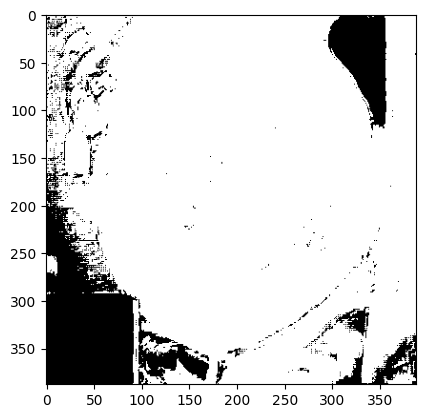

Train Epoch: 0 [0/1000 (0%)]	Loss: -6.011749


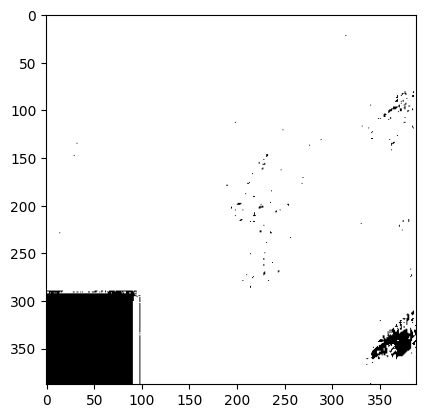

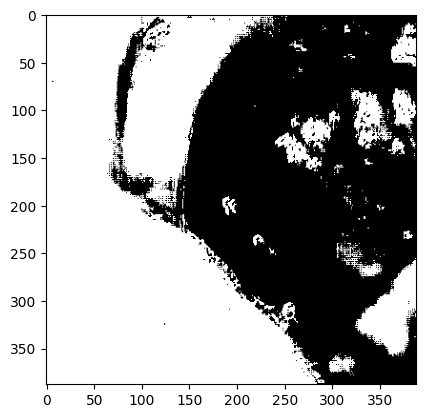

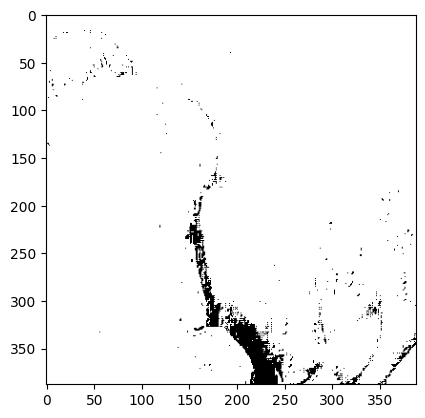

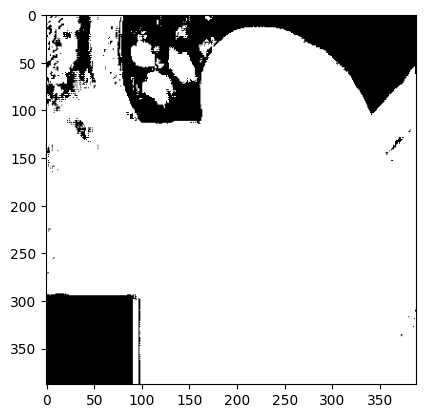

  0%|          | 0/16 [00:07<?, ?it/s]


KeyboardInterrupt: ignored

In [147]:
model = UNet()
model.to(device=DEVICE)
trainer = Trainer(model=model)
trainer.train()